In [1]:
import pyedflib
import numpy as np
from scipy import signal
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras 
import tensorflow as tf
import os, datetime
import seaborn as sns

In [2]:
samp = 256 # Sampling frequency

## Different electrode configuration for Subject 12
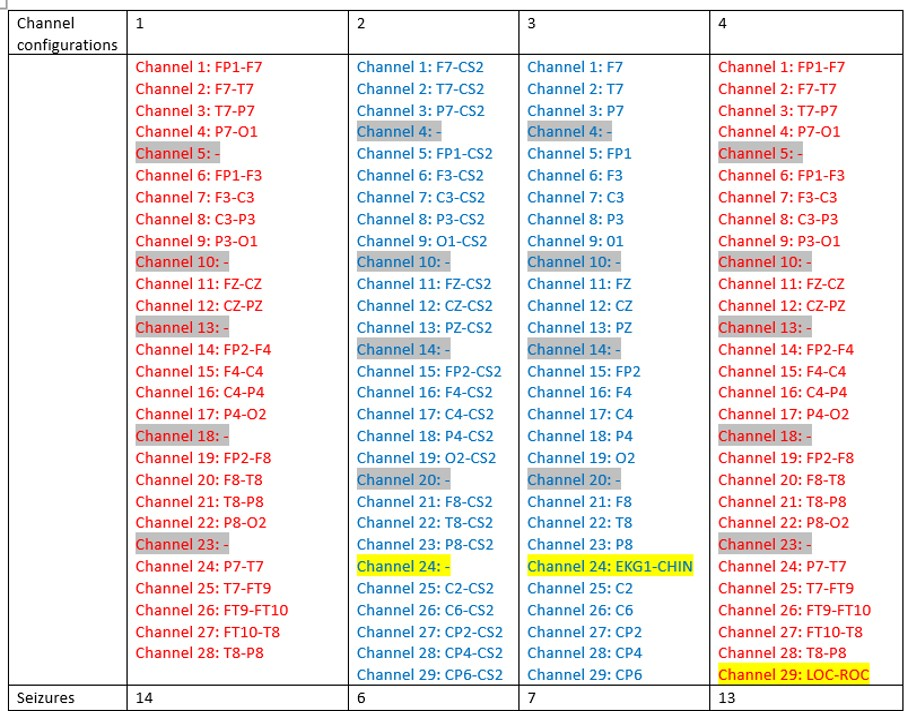

In [4]:
# Loading digitized .edf files for Subject 12 (Female, Age 2, 27 seizures)
# Loading recordings containing seizures only that can be found in sub12-sum.txt

edf_files = ['chb12_06', 'chb12_08', 'chb12_09', 'chb12_10', 'chb12_11', 'chb12_23'] # Configuration 1 recordings (Total: 6)
signals = []
for file in range(len(edf_files)):
    f = pyedflib.EdfReader('chbmit-sub12-dataset/' + edf_files[file] + '.edf') # Using 'pyedflib' library to load seizure .edf recordings
    n = f.signals_in_file 
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    sigbufs = np.transpose(sigbufs)
    sigbufs_df = pd.DataFrame(sigbufs)
    sigbufs_df = sigbufs_df.drop(columns=[4, 9, 12, 17, 22]) # Drop electrode data with zero signal
    sigbufs = np.array(sigbufs_df)
    signals.append(sigbufs)

# Read seizure 'start' and 'end' times from the summary file      
with open('chbmit-sub12-dataset/sub12-sum.txt') as f: 
    lines = [line.rstrip() for line in f]

seiz_list_1 = []
for i in range(len(lines)):
    for j in range(len(edf_files)):
        if ('File Name: ' + edf_files[j]) in lines[i]:
            for j in range(0, 13):
                if 'Seizure ' in lines[i+j]:
                    seiz_list_1.append(int(lines[i+j].split()[4]))

# Gather 'seizure' and 'preictal-seizure' segments from the recordings
seiz_dur_1 = []
seiz = []
preic_seiz = []

# Loop through all the seizures according to the specific recording
for i in range(0, len(seiz_list_1), 2):
      
    if i<=3:  #'chb12_06' seizures  
        seiz_dur_1_one = seiz_list_1[i+1]-seiz_list_1[i]
        seiz_dur_1.append(seiz_dur_1_one)
        seiz.append(signals[0][seiz_list_1[i]*samp:seiz_list_1[i+1]*samp])
        preic_seiz.append(signals[0][(seiz_list_1[i]-seiz_dur_1_one)*samp:seiz_list_1[i]*samp])

    elif i>3 and i<=11: #'chb12_08' seizures 
        seiz_dur_1_one = seiz_list_1[i+1]-seiz_list_1[i]
        seiz_dur_1.append(seiz_dur_1_one)
        seiz.append(signals[1][seiz_list_1[i]*samp:seiz_list_1[i+1]*samp])
        preic_seiz.append(signals[1][(seiz_list_1[i]-seiz_dur_1_one)*samp:seiz_list_1[i]*samp])

    elif i>11 and i<=15:  #'chb12_09' seizures 
        seiz_dur_1_one = seiz_list_1[i+1]-seiz_list_1[i]
        seiz_dur_1.append(seiz_dur_1_one)
        seiz.append(signals[2][seiz_list_1[i]*samp:seiz_list_1[i+1]*samp])
        preic_seiz.append(signals[2][(seiz_list_1[i]-seiz_dur_1_one)*samp:seiz_list_1[i]*samp])

    elif i>15 and i<=19: #'chb12_10' seizures     
        seiz_dur_1_one = seiz_list_1[i+1]-seiz_list_1[i]
        seiz_dur_1.append(seiz_dur_1_one)
        seiz.append(signals[3][seiz_list_1[i]*samp:seiz_list_1[i+1]*samp])
        preic_seiz.append(signals[3][(seiz_list_1[i]-seiz_dur_1_one)*samp:seiz_list_1[i]*samp])

    elif i>19 and i<=21:  #'chb12_11' seizures 
        seiz_dur_1_one = seiz_list_1[i+1]-seiz_list_1[i]
        seiz_dur_1.append(seiz_dur_1_one)
        seiz.append(signals[4][seiz_list_1[i]*samp:seiz_list_1[i+1]*samp])
        preic_seiz.append(signals[4][(seiz_list_1[i]-seiz_dur_1_one)*samp:seiz_list_1[i]*samp])

    else:  #'chb12_23' seizures   
        seiz_dur_1_one = seiz_list_1[i+1]-seiz_list_1[i]
        seiz_dur_1.append(seiz_dur_1_one)
        seiz.append(signals[5][seiz_list_1[i]*samp:seiz_list_1[i+1]*samp])
        preic_seiz.append(signals[5][(seiz_list_1[i]-seiz_dur_1_one)*samp:seiz_list_1[i]*samp])
        
# Reshape the signal to each of 1sec long (256 samples) and create train+test data
seiz_array = []
preic_array = []
seiz_array_test = []
preic_array_test = []

for i in range(len(seiz)):
    seiz_train = np.reshape(seiz[i], (int(seiz[i].shape[0]/256), 256, seiz[i].shape[1])) # Reshaping to 1sec long frames  
    indice = int(np.random.choice(seiz_train.shape[0], size=1, replace=False)) # Randomly selecting test data array for seizure signal
    seiz_test = seiz_train[indice:indice+1]
    seiz_train = np.delete(seiz_train, indice, axis=0)
    seiz_array.append(seiz_train)
    seiz_array_test.append(seiz_test)
    
    preic_train = np.reshape(preic_seiz[i], (int(preic_seiz[i].shape[0]/256), 256, preic_seiz[i].shape[1])) # Reshaping to 1sec long frames  
    indice = int(np.random.choice(preic_train.shape[0], size=1, replace=False)) # Randomly selecting test data array for precital signal
    preic_test = preic_train[indice:indice+1]
    preic_one = np.delete(preic_train, indice, axis=0)
    preic_array.append(preic_train)
    preic_array_test.append(preic_test)
    

seiz_df = pd.DataFrame()
seiz_df_test = pd.DataFrame()
seiz_df['Data'] = list(np.concatenate(seiz_array, axis=0))
seiz_df_test['Data'] = list(np.concatenate(seiz_array_test, axis=0))
seiz_df['Label'] = 1
seiz_df_test['Label'] = 1

preic_df = pd.DataFrame()
preic_df_test = pd.DataFrame()
preic_df['Data'] = list(np.concatenate(preic_array, axis=0))
preic_df_test['Data'] = list(np.concatenate(preic_array_test, axis=0))
preic_df['Label'] = 0
preic_df_test['Label'] = 0

arr_comb = [preic_df, seiz_df] # Combine train data for all the different recordings
arr_comb_test = [preic_df_test, seiz_df_test]  # Combine test data for all the different recordings

# Train and test dataframes for 'Configuration 1'
df_1 = pd.concat(arr_comb).reset_index(drop=True) 
df_test_1 = pd.concat(arr_comb_test).reset_index(drop=True) 

In [9]:
edf_files = ['chb12_27'] # Configuration 2 recordings (Total: 1)
signals = []
for file in range(len(edf_files)):
    f = pyedflib.EdfReader('chbmit-sub12-dataset/' + edf_files[file] + '.edf') # Using 'pyedflib' library to load seizure .edf recordings
    n = f.signals_in_file
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    sigbufs = np.transpose(sigbufs)
    sigbufs_df = pd.DataFrame(sigbufs)
    sigbufs_df = sigbufs_df.drop(columns=[3, 9, 13, 19, 23, 28]) # Drop electrode data with zero signal
    sigbufs = np.array(sigbufs_df)
    signals.append(sigbufs)

# Read seizure 'start' and 'end' times from the summary file      
with open('chbmit-sub12-dataset/sub12-sum.txt') as f:
    lines = [line.rstrip() for line in f]
    
seiz_list_2 = []
for i in range(len(lines)):
    for j in range(len(edf_files)):
        if ('File Name: ' + edf_files[j]) in lines[i]:
            for j in range(0, 16):
                if 'Seizure ' in lines[i+j]:
                    seiz_list_2.append(int(lines[i+j].split()[4]))

# Gather 'seizure' and 'preictal-seizure' segments from the recordings
seiz_dur_2 = []
seiz = []
preic_seiz = []

# Loop through all the seizures according to the specific recording
for i in range(0, len(seiz_list_2), 2): #'chb12_27' seizures  
    seiz_dur_2_one = seiz_list_2[i+1]-seiz_list_2[i]
    seiz_dur_2.append(seiz_dur_2_one)
    seiz.append(signals[0][seiz_list_2[i]*samp:seiz_list_2[i+1]*samp])
    preic_seiz.append(signals[0][(seiz_list_2[i]-seiz_dur_2_one)*samp:seiz_list_2[i]*samp])

# Reshape the signal to each of 1sec long (256 samples) and create train+test data
seiz_array = []
preic_array = []
seiz_array_test = []
preic_array_test = []

for i in range(len(seiz)):
    seiz_train = np.reshape(seiz[i], (int(seiz[i].shape[0]/256), 256, seiz[i].shape[1])) # Reshaping to 1sec long frames  
    indice = int(np.random.choice(seiz_train.shape[0], size=1, replace=False))  # Randomly selecting test data array for seizure signal 
    seiz_test = seiz_train[indice:indice+1]
    seiz_train = np.delete(seiz_train, indice, axis=0)
    seiz_array.append(seiz_train)
    seiz_array_test.append(seiz_test)
    
    preic_train = np.reshape(preic_seiz[i], (int(preic_seiz[i].shape[0]/256), 256, preic_seiz[i].shape[1])) # Reshaping to 1sec long frames    
    indice = int(np.random.choice(preic_train.shape[0], size=1, replace=False))  # Randomly selecting test data array for seizure signal 
    preic_test = preic_train[indice:indice+1]
    preic_one = np.delete(preic_train, indice, axis=0)
    preic_array.append(preic_train)
    preic_array_test.append(preic_test)
    

seiz_df = pd.DataFrame()
seiz_df_test = pd.DataFrame()
seiz_df['Data'] = list(np.concatenate(seiz_array, axis=0))
seiz_df_test['Data'] = list(np.concatenate(seiz_array_test, axis=0))
seiz_df['Label'] = 1
seiz_df_test['Label'] = 1

preic_df = pd.DataFrame()
preic_df_test = pd.DataFrame()
preic_df['Data'] = list(np.concatenate(preic_array, axis=0))
preic_df_test['Data'] = list(np.concatenate(preic_array_test, axis=0))
preic_df['Label'] = 0
preic_df_test['Label'] = 0

arr_comb = [preic_df, seiz_df] # Combine train data for all the different recordings
arr_comb_test = [preic_df_test, seiz_df_test] # Combine test data for all the different recordings

# Train and test dataframes for 'Configuration 2'
df_2 = pd.concat(arr_comb).reset_index(drop=True) 
df_test_2 = pd.concat(arr_comb_test).reset_index(drop=True) 

In [10]:
edf_files = ['chb12_28', 'chb12_29'] # Configuration 3 recordings (Total: 2)
signals = []
for file in range(len(edf_files)):
    f = pyedflib.EdfReader('chbmit-sub12-dataset/' + edf_files[file] + '.edf') # Using 'pyedflib' library to load seizure .edf recordings
    n = f.signals_in_file
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    sigbufs = np.transpose(sigbufs)
    sigbufs_df = pd.DataFrame(sigbufs)
    sigbufs_df = sigbufs_df.drop(columns=[3, 9, 13, 19, 27, 28]) # Drop electrode data with zero signal
    sigbufs = np.array(sigbufs_df)
    signals.append(sigbufs)
    
# Read seizure 'start' and 'end' times from the summary file  
with open('chbmit-sub12-dataset/sub12-sum.txt') as f:
    lines = [line.rstrip() for line in f]
    

seiz_list_3 = []
for i in range(len(lines)):
    for j in range(len(edf_files)):
        if ('File Name: ' + edf_files[j]) in lines[i] and j==0:            
            for k in range(0, 10):
                if 'Seizure ' in lines[i+k]:
                    seiz_list_3.append(int(lines[i+k].split()[4]))
        elif  ('File Name: ' + edf_files[j]) in lines[i] and j==1:
            for k in range(0, 16):
                if 'Seizure ' in lines[i+k]:
                    seiz_list_3.append(int(lines[i+k].split()[4]))

# Gather 'seizure' and 'preictal-seizure' segments from the recordings
seiz_dur_3 = []
seiz = []
preic_seiz = []

# Loop through all the seizures according to the specific recording
for i in range(0, len(seiz_list_3), 2):
    if i<=1: #'chb12_28' seizures 
        seiz_dur_3_one = seiz_list_3[i+1]-seiz_list_3[i]
        seiz_dur_3.append(seiz_dur_3_one)
        seiz.append(signals[0][seiz_list_3[i]*samp:seiz_list_3[i+1]*samp])
        preic_seiz.append(signals[0][(seiz_list_3[i]-seiz_dur_3_one)*samp:seiz_list_3[i]*samp])
    else: #'chb12_29' seizures 
        seiz_dur_3_one = seiz_list_3[i+1]-seiz_list_3[i]
        seiz_dur_3.append(seiz_dur_3_one)
        seiz.append(signals[1][seiz_list_3[i]*samp:seiz_list_3[i+1]*samp])
        preic_seiz.append(signals[1][(seiz_list_3[i]-seiz_dur_3_one)*samp:seiz_list_3[i]*samp])

# Reshape the signal to each of 1sec long (256 samples) and create train+test data        
seiz_array = []
preic_array = []
seiz_array_test = []
preic_array_test = []

for i in range(len(seiz)):
    seiz_train = np.reshape(seiz[i], (int(seiz[i].shape[0]/256), 256, seiz[i].shape[1])) # Reshaping to 1sec long frames 
    indice = int(np.random.choice(seiz_train.shape[0], size=1, replace=False)) # Randomly selecting test data array for seizure signal  
    seiz_test = seiz_train[indice:indice+1]
    seiz_train = np.delete(seiz_train, indice, axis=0)
    seiz_array.append(seiz_train)
    seiz_array_test.append(seiz_test)
    
    preic_train = np.reshape(preic_seiz[i], (int(preic_seiz[i].shape[0]/256), 256, preic_seiz[i].shape[1])) # Reshaping to 1sec long frames    
    indice = int(np.random.choice(preic_train.shape[0], size=1, replace=False)) # Randomly selecting test data array for seizure signal   
    preic_test = preic_train[indice:indice+1]
    preic_one = np.delete(preic_train, indice, axis=0)
    preic_array.append(preic_train)
    preic_array_test.append(preic_test)
    

seiz_df = pd.DataFrame()
seiz_df_test = pd.DataFrame()
seiz_df['Data'] = list(np.concatenate(seiz_array, axis=0))
seiz_df_test['Data'] = list(np.concatenate(seiz_array_test, axis=0))
seiz_df['Label'] = 1
seiz_df_test['Label'] = 1

preic_df = pd.DataFrame()
preic_df_test = pd.DataFrame()
preic_df['Data'] = list(np.concatenate(preic_array, axis=0))
preic_df_test['Data'] = list(np.concatenate(preic_array_test, axis=0))
preic_df['Label'] = 0
preic_df_test['Label'] = 0

arr_comb = [preic_df, seiz_df] # Combine train data for all the different recordings
arr_comb_test = [preic_df_test, seiz_df_test] # Combine test data for all the different recordings

# Train and test dataframes for 'Configuration 3'
df_3 = pd.concat(arr_comb).reset_index(drop=True) 
df_test_3 = pd.concat(arr_comb_test).reset_index(drop=True) 

In [11]:

edf_files = ['chb12_33', 'chb12_36', 'chb12_38', 'chb12_42'] # Configuration 4 recordings (Total: 4)
signals = []
for file in range(len(edf_files)):
    f = pyedflib.EdfReader('chbmit-sub12-dataset/' + edf_files[file] + '.edf') # Using 'pyedflib' library to load seizure .edf recordings
    n = f.signals_in_file
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    sigbufs = np.transpose(sigbufs)
    sigbufs_df = pd.DataFrame(sigbufs)
    sigbufs_df = sigbufs_df.drop(columns=[4, 9, 12, 17, 22, 28]) # Drop electrode data with zero signal
    sigbufs = np.array(sigbufs_df)
    signals.append(sigbufs)
    
# Read seizure 'start' and 'end' times from the summary file 
with open('chbmit-sub12-dataset/sub12-sum.txt') as f:
    lines = [line.rstrip() for line in f]
    
seiz_list_4 = []
for i in range(len(lines)):
    for j in range(len(edf_files)):
        if ('File Name: ' + edf_files[j]) in lines[i] and j==0:            
            for k in range(0, 12):
                if 'Seizure ' in lines[i+k]:
                    seiz_list_4.append(int(lines[i+k].split()[4]))
        elif  ('File Name: ' + edf_files[j]) in lines[i] and j==1:
            for k in range(0, 10):
                if 'Seizure ' in lines[i+k]:
                    seiz_list_4.append(int(lines[i+k].split()[4]))
        elif  ('File Name: ' + edf_files[j]) in lines[i] and j==2:
            for k in range(0, 16):
                if 'Seizure ' in lines[i+k]:
                    seiz_list_4.append(int(lines[i+k].split()[4]))           
        elif  ('File Name: ' + edf_files[j]) in lines[i] and j==3:
            for k in range(0, 14):
                if 'Seizure ' in lines[i+k]:
                    seiz_list_4.append(int(lines[i+k].split()[4]))

# Gather 'seizure' and 'preictal-seizure' segments from the recordings                    
seiz_dur_4 = []
seiz = []
preic_seiz = []

# Loop through all the seizures according to the specific recording
for i in range(0, len(seiz_list_4), 2):
    if i<=3: #'chb12_33' seizures 
        seiz_dur_4_one = seiz_list_4[i+1]-seiz_list_4[i]
        seiz_dur_4.append(seiz_dur_4_one)
        seiz.append(signals[0][seiz_list_4[i]*samp:seiz_list_4[i+1]*samp])
        preic_seiz.append(signals[0][(seiz_list_4[i]-seiz_dur_4_one)*samp:seiz_list_4[i]*samp])
    elif i>3 and i<=4: #'chb12_36' seizures 
        seiz_dur_4_one = seiz_list_4[i+1]-seiz_list_4[i]
        seiz_dur_4.append(seiz_dur_4_one)
        seiz.append(signals[1][seiz_list_4[i]*samp:seiz_list_4[i+1]*samp])
        preic_seiz.append(signals[1][(seiz_list_4[i]-seiz_dur_4_one)*samp:seiz_list_4[i]*samp])
    elif i>4 and i<=14: #'chb12_38' seizures 
        seiz_dur_4_one = seiz_list_4[i+1]-seiz_list_4[i]
        seiz_dur_4.append(seiz_dur_4_one)
        seiz.append(signals[2][seiz_list_4[i]*samp:seiz_list_4[i+1]*samp])
        preic_seiz.append(signals[2][(seiz_list_4[i]-seiz_dur_4_one)*samp:seiz_list_4[i]*samp])
    else: #'chb12_42' seizures 
        seiz_dur_4_one = seiz_list_4[i+1]-seiz_list_4[i]
        seiz_dur_4.append(seiz_dur_4_one)
        seiz.append(signals[3][seiz_list_4[i]*samp:seiz_list_4[i+1]*samp])
        preic_seiz.append(signals[3][(seiz_list_4[i]-seiz_dur_4_one)*samp:seiz_list_4[i]*samp])

# Reshape the signal to each of 1sec long (256 samples) and create train+test data         
seiz_array = []
preic_array = []
seiz_array_test = []
preic_array_test = []

for i in range(len(seiz)):
    seiz_train = np.reshape(seiz[i], (int(seiz[i].shape[0]/256), 256, seiz[i].shape[1])) # Reshaping to 1sec long frames 
    indice = int(np.random.choice(seiz_train.shape[0], size=1, replace=False)) # Randomly selecting test data array for seizure signal    
    seiz_test = seiz_train[indice:indice+1]
    seiz_train = np.delete(seiz_train, indice, axis=0)
    seiz_array.append(seiz_train)
    seiz_array_test.append(seiz_test)
    
    preic_train = np.reshape(preic_seiz[i], (int(preic_seiz[i].shape[0]/256), 256, preic_seiz[i].shape[1])) # Reshaping to 1sec long frames    
    indice = int(np.random.choice(preic_train.shape[0], size=1, replace=False)) # Randomly selecting test data array for seizure signal    
    preic_test = preic_train[indice:indice+1]
    preic_one = np.delete(preic_train, indice, axis=0)
    preic_array.append(preic_train)
    preic_array_test.append(preic_test)
    

seiz_df = pd.DataFrame()
seiz_df_test = pd.DataFrame()
seiz_df['Data'] = list(np.concatenate(seiz_array, axis=0))
seiz_df_test['Data'] = list(np.concatenate(seiz_array_test, axis=0))
seiz_df['Label'] = 1
seiz_df_test['Label'] = 1

preic_df = pd.DataFrame()
preic_df_test = pd.DataFrame()
preic_df['Data'] = list(np.concatenate(preic_array, axis=0))
preic_df_test['Data'] = list(np.concatenate(preic_array_test, axis=0))
preic_df['Label'] = 0
preic_df_test['Label'] = 0

arr_comb = [preic_df, seiz_df] # Combine train data for all the different recordings
arr_comb_test = [preic_df_test, seiz_df_test] # Combine test data for all the different recordings

# Train and test dataframes for 'Configuration 4'
df_4 = pd.concat(arr_comb).reset_index(drop=True) 
df_test_4 = pd.concat(arr_comb_test).reset_index(drop=True) 

In [15]:
df_train = pd.concat([df_1, df_2, df_3, df_4]).reset_index(drop=True)
df_test = pd.concat([df_test_1, df_test_2, df_test_3, df_test_4]).reset_index(drop=True)

pd.DataFrame.to_json(df_test, 'sub12-seiz-Test.json')
pd.DataFrame.to_json(df_train, 'sub12-seiz-Train.json')

In [13]:
#Seizure statistics  

seiz_dur = seiz_dur_1 + seiz_dur_2 + seiz_dur_3 + seiz_dur_4
min(seiz_dur), max(seiz_dur), np.mean(seiz_dur), sum(seiz_dur), sum(seiz_dur)/60

(13, 97, 36.875, 1475, 24.583333333333332)